# ESM Example from Facebook research github repo

Using esm_tcr conda environment to run esm on CPU

In [2]:
import torch
import esm
import matplotlib.pyplot as plt

In [3]:
# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bia

In [5]:
# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein3",  "K A <mask> I S Q"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

print(batch_labels)
print(batch_lens)

['protein1', 'protein2', 'protein2 with mask', 'protein3']
tensor([67, 73, 73,  8])


In [6]:
# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
token_representations = results["representations"][33]

In [7]:
# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, tokens_len in enumerate(batch_lens):
    sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))

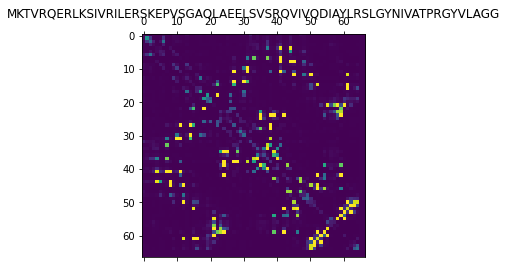

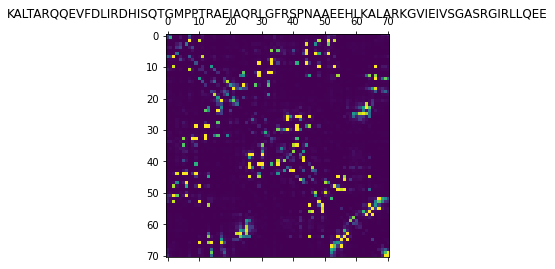

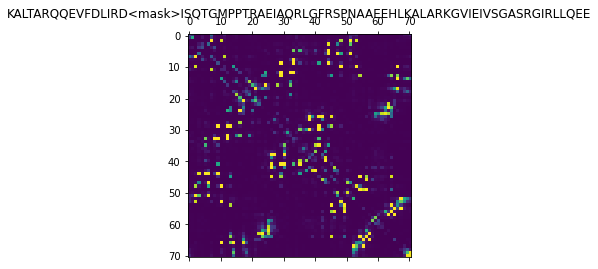

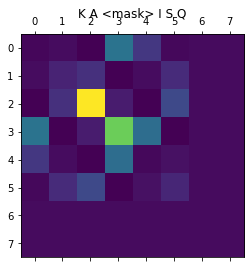

In [8]:
# Look at the unsupervised self-attention map contact predictions
for (_, seq), tokens_len, attention_contacts in zip(data, batch_lens, results["contacts"]):
    plt.matshow(attention_contacts[: tokens_len, : tokens_len])
    plt.title(seq)
    plt.show()